# House Prices - Advanced Regression Techniques
(Preços de casas - Técnicas Avançadas de Regressão)

<img src="../relatorios/imagens/housesbanner.png" width=800>


- Vamos utilizar o [dataset disponível no Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)
    - É um dataset de **competição**
    - Temos uma base com a **descrição de cada uma das colunas (data_description.txt)**
    - Tem também um arquivo 'md' com as colunas traduzidas, e com um pouco mais de informação, que são resultados da análise do **ProfileReport**, chamado "01_dicionario_de_dados.md" na pasta 'referencias'.

In [2]:
# Importando as bibliotecas.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fixando a aleatoriedade
RANDOM_STATE = 42

# Definindo um tema para os gráficos.
# sns.set_theme(palette='bright')

# Filtrando os Warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importando os datasets e visualizando

df_treino = pd.read_csv("../dados/train.csv")
df_teste = pd.read_csv("../dados/test.csv")

df_treino.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Verificando as informações
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<a id="index"></a>
## Começando a explorar os dados
- **Index:**
    - [PoolQC, MiscFeature, Alley, Fence](#top4)
    - [FireplaceQu](#FireplaceQu)
    - [LotFrontage](#LotFrontage)
    - [colunas de Garagem](#garagem)
    - [colunas de Porão](#porao)
    - [MasVnrType, MasVnrArea, Electrical system](#restante)
    - [Analisando o restante das colunas de teste](#restante_teste)

In [6]:
# Calculando % a quantidade de valores vazios
df_valores_faltantes = pd.DataFrame(
    {"Colunas": df_treino.count().values, 
    "Percentual_NaN": (df_treino.isnull().sum().values / len(df_treino)) * 100},
    index= df_treino.count().index
)

df_valores_faltantes[df_valores_faltantes['Percentual_NaN'] > 0].sort_values(by="Percentual_NaN", ascending=False)

,Colunas,Percentual_NaN
PoolQC,7,99.520548
MiscFeature,54,96.301370
Alley,91,93.767123
Fence,281,80.753425
MasVnrType,588,59.726027
FireplaceQu,770,47.260274
LotFrontage,1201,17.739726
GarageType,1379,5.547945
GarageYrBlt,1379,5.547945
GarageFinish,1379,5.547945


<a id='4top'></a>
- **As 4 primeiras colunas tem mais de 80% dos valores vazios na base de treino**
    - Ao invés de eliminar essas colunas, vamos entender cada um dos dados:
        - **PoolQC**: **Qualidade** da piscina
            - NA: No Pool(sem piscina)
        - **MiscFeature**: Qualquer recurso não considerado nas outras categorias
            - NA: None
        - **Alley**: Tipo de beco / ruela para acesso a propriedade
            - NA: No alley access
        - **Fence**: **Qualidade** da cerca
            - NA: No Fence


- Nesse caso **o NA não é ausência de informação, <font color='red'>ele é uma informação</font>**


- Podemos entender melhor os dados nessas colunas e principalmente sua **relação com o preço de venda**

In [8]:
# Podemos substituir os valores vazios na primeira coluna por -1
df_treino[['PoolQC', 'MiscFeature', 'Alley', 'Fence']] = df_treino[['PoolQC', 'MiscFeature', 'Alley', 'Fence']].fillna(-1)

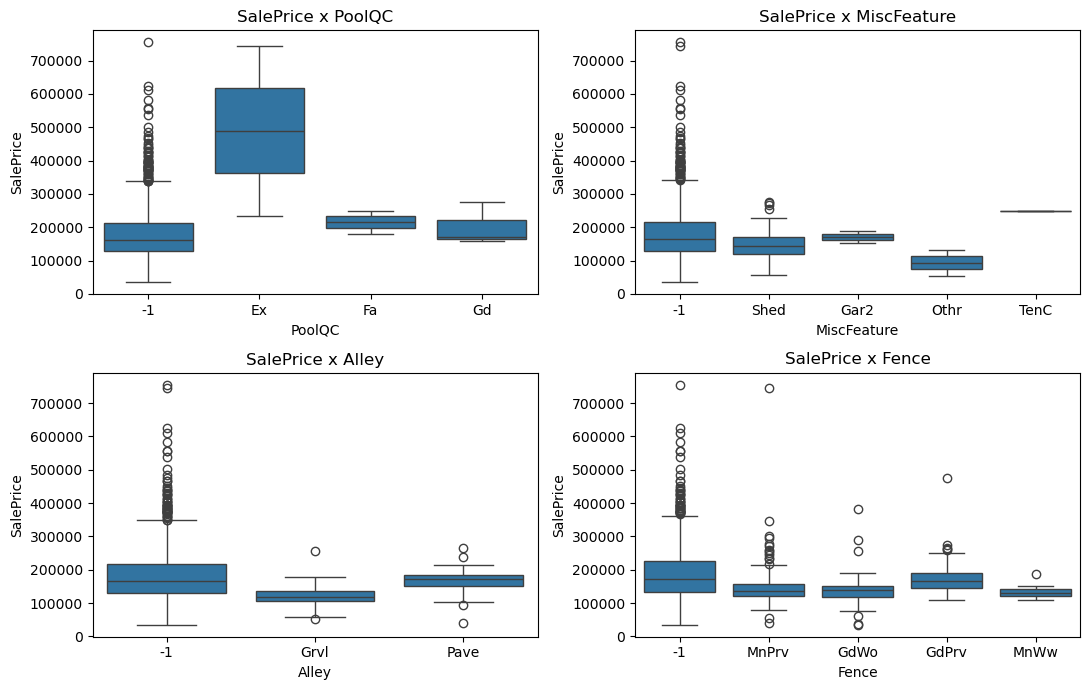

In [9]:
# Visualizando a relação com o preço
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(11, 7), tight_layout=True)

sns.boxplot(data=df_treino, x='PoolQC', y='SalePrice', ax=ax[0,0])
ax[0,0].set_title('SalePrice x PoolQC')
sns.boxplot(data=df_treino, x='MiscFeature', y='SalePrice', ax=ax[0,1])
ax[0,1].set_title('SalePrice x MiscFeature')
sns.boxplot(data=df_treino, x='Alley', y='SalePrice', ax=ax[1,0])
ax[1,0].set_title('SalePrice x Alley')
sns.boxplot(data=df_treino, x='Fence', y='SalePrice', ax=ax[1,1])
ax[1,1].set_title('SalePrice x Fence')
plt.show()

- **Vamos começar a já fazer os mesmos tratamentos para a <font color='blue'>base de teste</font>** 
    - (depois vamos automatizar esse processo, mas por enquanto vamos fazer o passo a passo de cada etapa)

In [11]:
# Verificando o shape da base de treino
df_treino.shape

(1460, 81)

In [12]:
# Ajustando também para a base de teste
df_teste[['PoolQC', 'MiscFeature', 'Alley', 'Fence']] = df_teste[['PoolQC', 'MiscFeature', 'Alley', 'Fence']].fillna(-1)

In [13]:
# Verificando o shape da base de teste
df_teste.shape

(1459, 80)

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id=FireplaceQu></a>
- **Agora analisando a coluna <font color='blue'>FireplaceQu</font>**
- Temos 2 colunas relacionadas a lareiras:
    - **Fireplaces**: Number of fireplaces
    - **FireplaceQu**: Fireplace quality

In [16]:
# Visualizando a quantidade de registros em cada rótulo
df_treino[['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            690
1           Gd             324
            TA             259
2           Gd              54
            TA              53
1           Fa              28
            Po              20
            Ex              19
2           Fa               4
            Ex               4
3           Gd               2
            Ex               1
            Fa               1
            TA               1
Name: count, dtype: int64

- Esse NaN também é uma informação, dizendo que **não existe lareira**

In [18]:
# Ajustando essa coluna
df_treino[['FireplaceQu']] = df_treino[['FireplaceQu']].fillna(-1)

- Novamente fazendo o mesmo para a **<font color='blue'>base de teste</font>**

In [20]:
# Visualizando a quantidade de registros em cada rótulo
df_teste[['Fireplaces', 'FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            730
1           Gd             303
            TA             236
2           Gd              58
            TA              39
1           Fa              35
            Po              26
            Ex              18
2           Fa               6
3           TA               3
            Gd               3
2           Ex               1
4           TA               1
Name: count, dtype: int64

In [21]:
# Fazendo a transformação para a base de teste
df_teste[['FireplaceQu']] = df_teste[['FireplaceQu']].fillna(-1)

- **Visualizando novamente as informações de valores vazios**

In [23]:
# Calculando % a quantidade de valores vazios
(df_treino.isnull().sum()/df_treino.shape[0] * 100).sort_values(ascending=False).head(15)

MasVnrType      59.726027
LotFrontage     17.739726
GarageType       5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageYrBlt      5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

In [24]:
# Verificando a quantidade de valores
df_treino.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      872
LotFrontage     259
GarageType       81
GarageCond       81
GarageFinish     81
GarageYrBlt      81
GarageQual       81
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
dtype: int64

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id=LotFrontage></a>
- **<font color='blue'>LotFrontage</font>: Pés lineares (medida de distância) de rua conectados à propriedade**

In [27]:
# Entendendo os tipos de propriedades que possuem valor nulo
df_treino.loc[df_treino['LotFrontage'].isnull(), 'LotConfig'].value_counts()

LotConfig
Inside     134
Corner      62
CulDSac     49
FR2         14
Name: count, dtype: int64

In [28]:
# Verificando a média por tipo de propriedade
df_treino.groupby('LotConfig')['LotFrontage'].mean()

LotConfig
Corner     84.039801
CulDSac    59.911111
FR2        63.515152
FR3        70.750000
Inside     67.715686
Name: LotFrontage, dtype: float64

- Nesse caso o valor vazio **parece um erro da base**

In [30]:
# Substituindo os valores vazios pela média em relação ao LotConfig
df_treino['LotFrontage'] = df_treino['LotFrontage'].fillna(df_treino.groupby('LotConfig')['LotFrontage'].transform('mean'))

- Para a **<font color='blue'>base de teste</font>**

In [32]:
# Fazendo para a base de teste
df_teste['LotFrontage'] = df_teste['LotFrontage'].fillna(df_teste.groupby('LotConfig')['LotFrontage'].transform('mean'))

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id="garagem"></a>
- **Avaliando as <font color='blue'>colunas de garagem</font>**
    - **GarageType**: Garage location
        - **NA: No Garage**
    - **GarageYrBlt**: Year garage was built
	- **GarageFinish**: Interior finish of the garage
        - **NA: No Garage**		
    - **GarageCars**: Size of garage in car capacity
	- **GarageArea**: Size of garage in square feet
	- **GarageQual**: Garage quality
        - **NA: No Garage**		
	- **GarageCond**: Garage condition
        - **NA: No Garage**		

In [35]:
# Verificando as colunas que possuem garagem no nome
col_garagem = df_treino.columns[df_treino.columns.str.contains('Garage')]
col_garagem

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [36]:
# Filtrando a base
df_treino.loc[df_treino['GarageCond'].isnull(), col_garagem].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0           0           NaN         NaN           81
Name: count, dtype: int64

- **O NaN em todas essas colunas é que não existe garagem**

In [38]:
# Podemos selecionar apenas as colunas vazias
df_treino.loc[df_treino['GarageType'].isnull(), col_garagem[[0,1,2,5,6]]].head()

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN


In [39]:
# Verificando os valores
df_treino.loc[df_treino['GarageType'].isnull(), col_garagem[[0,1,2,5,6]]].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageQual  GarageCond
NaN         NaN          NaN           NaN         NaN           81
Name: count, dtype: int64

In [40]:
# E substituir esses valores por -1
df_treino.loc[df_treino['GarageType'].isnull(), col_garagem[[0,1,2,5,6]]] = -1

In [41]:
# Verificando novamente quando a quantidade de carros é igual a 0
df_treino.loc[df_treino['GarageCars'] == 0, col_garagem].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
-1          -1.0         -1            0           0           -1          -1            81
Name: count, dtype: int64

In [42]:
# Resumindo os valores vazios da base de treino
df_treino.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      872
BsmtExposure     38
BsmtFinType2     38
BsmtCond         37
BsmtFinType1     37
BsmtQual         37
MasVnrArea        8
Electrical        1
LandContour       0
MSSubClass        0
dtype: int64

- Para a **<font color='blue'>base de teste</font>**

In [44]:
# Verificando os valores
df_teste.loc[df_teste['GarageCond'].isnull(), col_garagem].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0.0         0.0         NaN         NaN           76
Detchd      NaN          NaN           1.0         360.0       NaN         NaN            1
                                       NaN         NaN         NaN         NaN            1
Name: count, dtype: int64

- Tratando a linha onde GarageCars é zero e tudo é vazio

In [46]:
# Analisando a condição de GarageType ser nulo
df_teste.loc[df_teste['GarageType'].isnull(), col_garagem[[0,1,2,5,6]]].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageQual  GarageCond
NaN         NaN          NaN           NaN         NaN           76
Name: count, dtype: int64

In [47]:
# E substituir esses valores por -1
df_teste.loc[df_teste['GarageType'].isnull(), col_garagem[[0,1,2,5,6]]] = -1

- Agora vamos entender as colunas com tudo vazio mas GarageType = "Detchd"

In [49]:
# Entendendo essas colunas
df_teste.loc[df_teste['GarageCond'].isnull(), col_garagem]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


- Analisando a coluna GarageYrBlt

In [51]:
# Vamos verificar os valores quando GarageType == "Detchd"
df_teste2 = df_teste.loc[(df_teste.GarageType == 'Detchd') & (df_teste.GarageYrBlt != -1)]
df_teste2.corr(numeric_only=True)['GarageYrBlt'].sort_values(ascending=False).head()

GarageYrBlt     1.000000
YearBuilt       0.615951
GarageArea      0.494670
GarageCars      0.413711
YearRemodAdd    0.321667
Name: GarageYrBlt, dtype: float64

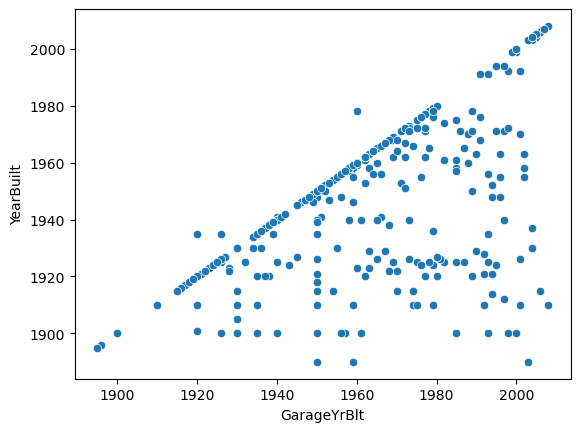

In [52]:
# Visualizando essa correlação
sns.scatterplot(data=df_teste2, x='GarageYrBlt', y='YearBuilt')
plt.show()

Há um correlação positiva alta entre o **ano de construção da garagem(GarageYrBlt)**, com o **ano de construção da casa(YearBuilt)**. Faz sentido se levarmos em consideração que geralmente a garagem é construída junto com a casa.

In [54]:
# Verificando a nova coluna
df_teste['CheckAnos'] = df_teste['GarageYrBlt'] == df_teste['YearBuilt']
df_teste.CheckAnos.value_counts()

CheckAnos
True     1127
False     332
Name: count, dtype: int64

É possível observar que em 1127 casos a Garagem foi contruída no mesmo ano que a Casa, ou seja, maioria.

E parte dos valores em que isso não aconteceu, 76 deles são valores vazios(-1), porque não tem garagem.

Como pode ser visto na célula abaixo:

In [56]:
df_teste[(df_teste.CheckAnos == False) & (df_teste.GarageYrBlt == -1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,CheckAnos
53,1514,90,RL,98.0,13260,Pave,-1,IR1,Lvl,AllPub,...,0,-1,-1,-1,0,1,2010,Oth,Abnorml,False
71,1532,30,RM,56.0,4485,Pave,Grvl,Reg,Lvl,AllPub,...,0,-1,MnPrv,-1,0,5,2010,WD,Normal,False
79,1540,190,RM,100.0,9045,Pave,-1,Reg,Lvl,AllPub,...,0,-1,-1,-1,0,6,2010,WD,Abnorml,False
92,1553,70,RM,60.0,12900,Pave,Grvl,Reg,Lvl,AllPub,...,0,-1,-1,-1,0,5,2010,WD,Normal,False
96,1557,190,RL,60.0,9900,Pave,-1,Reg,Lvl,AllPub,...,0,-1,-1,-1,0,2,2010,ConLD,Normal,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2894,50,C (all),60.0,8520,Grvl,-1,Reg,Bnk,AllPub,...,0,-1,-1,-1,0,4,2006,WD,Normal,False
1449,2910,180,RM,21.0,1470,Pave,-1,Reg,Lvl,AllPub,...,0,-1,-1,-1,0,4,2006,WD,Normal,False
1453,2914,160,RM,21.0,1526,Pave,-1,Reg,Lvl,AllPub,...,0,-1,GdPrv,-1,0,6,2006,WD,Normal,False
1454,2915,160,RM,21.0,1936,Pave,-1,Reg,Lvl,AllPub,...,0,-1,-1,-1,0,6,2006,WD,Normal,False


Isso significa que supor que a garagem foi contruída no mesmo ano que a casa não é uma suposição grotesca. Existe evidências que dizem que é bastante provável. Como não possuimos informações direto da fonte(negócio), essa é a suposição que iremos implementar.

In [58]:
# Apagando essa coluna
df_teste = df_teste.drop('CheckAnos', axis=1)

In [59]:
# Verificando os valores de construção da casa
df_teste.loc[df_teste.GarageYrBlt.isnull(), 'YearBuilt'] 

666     1910
1116    1923
Name: YearBuilt, dtype: int64

In [60]:
# Substituindo as colunas vazias pelo ano de construção da casa
df_teste.loc[df_teste.GarageCond.isnull(), 'GarageYrBlt'] = df_teste.loc[df_teste.GarageYrBlt.isnull(), 'YearBuilt'] 

- E a coluna GarageFinish

In [62]:
# Vamos verificar os valores quando GarageType == "Detchd"
df_teste.loc[df_teste['GarageType'] == 'Detchd', 'GarageFinish'].value_counts()

GarageFinish
Unf    365
RFn     15
Fin     10
Name: count, dtype: int64

No caso da coluna **GarageFinish** percebemos que o valor mais frequente é muito maior do que os outros, nesse caso até faz sentido utilizar a **moda** para substituir os valores ausentes; Se existissem duas modas ou mais, talvez essa não seria a melhor opção.

In [64]:
# Podemos substituir pelo valor mais frequente
moda_garagefinish = df_teste.loc[df_teste['GarageType'] == 'Detchd', 'GarageFinish'].mode()[0]
moda_garagefinish

'Unf'

In [65]:
df_teste.loc[(df_teste['GarageType'] == 'Detchd') & (df_teste['GarageFinish'].isnull()), 'GarageFinish'] = moda_garagefinish

- Fazendo o mesmo para GarageQual e GarageCond

In [67]:
# Vamos verificar os valores quando GarageType == "Detchd"
df_teste.loc[df_teste['GarageType'] == 'Detchd', ['GarageQual', 'GarageCond']].value_counts()

GarageQual  GarageCond
TA          TA            309
Fa          TA             38
            Fa             19
TA          Fa             16
Fa          Po              3
Gd          Ex              1
Po          Po              1
            Fa              1
TA          Gd              1
            Po              1
Name: count, dtype: int64

No caso dessas duas colunas de Garagem, temos que nos atentar ao fato do que levou o funcionário a classificar as casas com essas respectivas condições e qualidades. Podemos nos perguntar: "porque a maioria das pessoas avaliaram como sendo **na média**, será que faz sentido ?"; Teriamos que ter um entendimento do **negócio** mais profundo, conhecendo melhor a pessoa que avalia as Garagens. As vezes avaliar a qualidade e condição da Garagem como sendo **ruim**, faça com que o dono da casa reclame e ache que isso vai ser um problema, e isso vai dar uma dor de cabeça tão grande para o avaliador que ele simplesmente, para evitar isso, diz **que a Garagem está na média**. A mesma coisa pode acontecer se o avaliador avalie a Garagem como sendo excelente, ai o comprador diz que não está excelente, gerando novamente uma dor de cabeça. As vezes o avaliador pode acabar enviesando os dados simplesmente porque aquilo é mais fácil pra ele, e não porque aquilo é a informação verdadeira. Claro que isso são suposição, e teriamos que testar na prática para ver se isso realmente acontece, seria necessário entender todo o contexto da empresa.

In [69]:
# Podemos verificar a moda dessa coluna
moda_garagequal = df_teste.loc[df_teste['GarageType'] == 'Detchd', 'GarageQual'].mode()[0]
moda_garagecond = df_teste.loc[df_teste['GarageType'] == 'Detchd', 'GarageCond'].mode()[0]
moda_garagequal, moda_garagequal

('TA', 'TA')

In [70]:
# E usar esse valor no GarageQual
df_teste.loc[(df_teste['GarageType'] == 'Detchd') & (df_teste['GarageQual'].isnull()), 'GarageQual'] = moda_garagequal

In [71]:
# E fazer o mesmo para GarageCond
df_teste.loc[(df_teste['GarageType'] == 'Detchd') & (df_teste['GarageCond'].isnull()), 'GarageCond'] = moda_garagecond

In [72]:
# Verificando os valores nulos novamente
df_teste.loc[(df_teste['GarageCars'].isnull()) & (df_teste['GarageArea'].isnull()), col_garagem]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
1116,Detchd,1923.0,Unf,NaN,NaN,TA,TA


- Para finalizar as colunas de garagem, vamos tratar GarageCars e GarageArea

Para as colunas de GarageCars e GarageArea o tratamento vai ser um pouco diferente, tendo em vista que estamos falando de colunas que possuem valores **contínuos**, nesse caso a moda, não faria muito sentido. Faremos o tratamento utilizando a **média** de cada coluna.

In [75]:
# A célula onde os valore são nulos
df_teste.loc[(df_teste['GarageType'] == 'Detchd') & (df_teste['GarageArea'].isnull()), ['GarageArea', 'GarageCars']]

,GarageArea,GarageCars
1116,NaN,NaN


In [76]:
# Agora vamos visualizar a média desses valores quando GarageType == "Detchd"
media_carros = df_teste.loc[(df_teste['GarageType'] == 'Detchd'), ['GarageCars', 'GarageArea']].mean()
media_carros

GarageCars      1.519182
GarageArea    412.202046
dtype: float64

In [77]:
# Como Não podemos ter meio carro, vamos arredondar os valores
media_carros = round(media_carros, 0)
media_carros.values

array([  2., 412.])

In [78]:
# Podemos usar esses valores se a média for vazia
df_teste.loc[(df_teste['GarageType'] == 'Detchd') & (df_teste['GarageCars'].isnull()), 'GarageCars'] = media_carros[0]
df_teste.loc[(df_teste['GarageType'] == 'Detchd') & (df_teste['GarageArea'].isnull()), 'GarageArea'] = media_carros[1]

In [79]:
# Visualizando novamente aquelas duas linhas que tinham valores vazios
df_teste.iloc[[666, 1116], 55:70]

,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch
666,Typ,0,-1,Detchd,1910.0,Unf,1.0,360.0,TA,TA,Y,64,0,180,0
1116,Typ,0,-1,Detchd,1923.0,Unf,2.0,412.0,TA,TA,Y,174,0,212,0


In [80]:
# Resumindo os valores vazios da base de teste
df_teste.isnull().sum().sort_values(ascending=False).head(21)

MasVnrType      894
BsmtCond         45
BsmtExposure     44
BsmtQual         44
BsmtFinType2     42
BsmtFinType1     42
MasVnrArea       15
MSZoning          4
BsmtFullBath      2
Utilities         2
BsmtHalfBath      2
Functional        2
TotalBsmtSF       1
BsmtFinSF1        1
Exterior2nd       1
Exterior1st       1
SaleType          1
KitchenQual       1
BsmtUnfSF         1
BsmtFinSF2        1
LandSlope         0
dtype: int64

<a id="porao"></a>
- **E fazendo a mesma coisa para as <font color='blue'>colunas de Porão</font>**
    - **NA: No Basement**
- **Voltando para a base de dados de treino**

In [82]:
# Verificando as colunas que possuem porão no nome e possuem valores vazios
col_porao = df_treino.columns[(df_treino.columns.str.contains('Bsmt')) & (df_treino.isnull().any())]
col_porao

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], dtype='object')

In [83]:
# Analisando os valores
df_treino.loc[df_treino['BsmtFinType2'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Gd        TA        No            GLQ           NaN              1
Name: count, dtype: int64

In [84]:
# Analisando para a coluna 'BsmtExposure'
df_treino.loc[df_treino['BsmtExposure'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Gd        TA        NaN           Unf           Unf              1
Name: count, dtype: int64

Duas colunas especificamente, possuem valores nulos, porém nas outras colunas possuem valores preenchidos, nesse caso não podemos supor que os valores nulos das colunas **BsmtExpose** e **BsmtFinType2** é porque são casas que não tem porão, temos que tratar esses valores individualmente.

In [86]:
# Focando na coluna 'BsmtFinType2', verificando o valor mais frequente.
df_treino['BsmtFinType2'].value_counts()

BsmtFinType2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64

In [87]:
# Obtendo a moda dessa coluna utilizando critérios mais específicos
moda_BsmtFinType2 = df_treino.loc[
    (df_treino.BsmtQual == 'Gd') &
    (df_treino.BsmtExposure == 'No') &
    (df_treino.BsmtCond == 'TA'),
    'BsmtFinType2'
].mode()[0]

moda_BsmtFinType2

'Unf'

In [88]:
# Substituindo o valor nulo pela moda.
df_treino.loc[(df_treino.BsmtQual == 'Gd') & (df_treino.BsmtFinType2.isnull()), 'BsmtFinType2'] = moda_BsmtFinType2

In [89]:
# Confirmando se realmente foi tratado o valor nulo.
df_treino.loc[df_treino['BsmtFinType2'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Name: count, dtype: int64

In [90]:
# Agora tratando a coluna 'BsmtExposure'
df_treino['BsmtExposure'].value_counts()

BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64

In [91]:
# Obtendo a moda dessa coluna utilizando critérios mais específicos
moda_BsmtExposure = df_treino.loc[
    (df_treino.BsmtQual == 'Gd') &
    (df_treino.BsmtExposure == 'No') &
    (df_treino.BsmtCond == 'TA'),
    'BsmtExposure'
].mode()[0]

moda_BsmtExposure

'No'

In [92]:
# Substituindo o valor nulo pela moda.
df_treino.loc[(df_treino['BsmtQual'] == 'Gd') & (df_treino['BsmtExposure'].isnull()), 'BsmtExposure'] = moda_BsmtExposure

In [93]:
# Confirmando se realmente foi tratado o valor nulo.
df_treino.loc[df_treino['BsmtExposure'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Name: count, dtype: int64

- Agora considerando as colunas que BsmtQual e BsmtCond são vazias

In [95]:
# Verificando os valores com BsmtQual vazio
df_treino.loc[df_treino['BsmtQual'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Name: count, dtype: int64

In [96]:
# Verificando os valores com BsmtCond vazio
df_treino.loc[df_treino['BsmtCond'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Name: count, dtype: int64

- Nesse caso, acessando a Descrição dos Dados percebe-se que esses valores vazios em todas as colunas significam que essas casas **não possuem porão**

In [98]:
# Substituindo os valores sem porão por -1
df_treino.loc[df_treino['BsmtCond'].isnull(), col_porao] = -1

In [99]:
# Visualizando os valores vazios
df_treino.isnull().sum().sort_values(ascending=False).head(8)

MasVnrType     872
MasVnrArea       8
Electrical       1
MSSubClass       0
LotArea          0
Street           0
MSZoning         0
LotFrontage      0
dtype: int64

O mesmo para a base de **<font color=Blue>teste</font>**

In [101]:
# Analisando os valores
df_teste.loc[df_teste['BsmtQual'].isnull(), col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             42
          Fa        No            Unf           Unf              1
          TA        No            Unf           Unf              1
Name: count, dtype: int64

- Começando a tratar a coluna BsmtQual

In [103]:
# Trabalhando tratando a base de teste
col_porao_teste = df_teste.columns[(df_teste.columns.str.contains('Bsmt')) & (df_teste.isnull().any())]
col_porao_teste

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [104]:
# Analisando os valores
df_teste.loc[df_teste.BsmtQual.isnull(), col_porao_teste].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
          Fa        No            Unf           0.0         Unf           0.0         173.0      173.0        0.0           0.0              1
          TA        No            Unf           0.0         Unf           0.0         356.0      356.0        0.0           0.0              1
          NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
Name: count, dtype: int64

In [105]:
# Indo além
df_teste.loc[(df_teste.BsmtQual.isnull()) & (df_teste.BsmtCond.notnull()), col_porao_teste]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


In [106]:
# Podemos verificar o valor mais frequente
df_teste.BsmtQual.value_counts()

BsmtQual
TA    634
Gd    591
Ex    137
Fa     53
Name: count, dtype: int64

Nesse temos mais de um valor sendo bastante frequente na coluna que estamos tratando, talvez seja adequado aplicar mais filtros; ser mais específico na avaliação da moda.

In [108]:
# Fazendo a agregação pelas colunas que nos ajudam a realizar um filtro mais específico
df_teste.groupby(['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2'])['BsmtQual'].agg(pd.Series.mode)

BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2
Fa        Av            BLQ           749.0       Rec             Gd
                        GLQ           870.0       Unf             Gd
                        LwQ           646.0       Unf             TA
          Mn            ALQ           361.0       Rec             Gd
                                      890.0       Unf             TA
                                                                  ..
TA        No            Rec           1026.0      Unf             TA
                                      1116.0      Unf             TA
                                      1173.0      Unf             TA
                                      1312.0      Unf             TA
                        Unf           0.0         Unf             TA
Name: BsmtQual, Length: 951, dtype: object

Aparentemente, o valor de moda para a coluna inteira é o mesmo para essas duas linhas com valores nulos em **BsmtQual** 

Assim, podemos substituir as linhas com valores faltando utilizando essas mesmas regras de filtro com agregação.

In [110]:
# Selecionando a moda de forma contextualizada
moda_BsmtQual = df_teste.loc[(df_teste.BsmtQual.isnull()) & (df_teste.BsmtCond.notnull()), 'BsmtQual'].fillna(df_teste.groupby([
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2'
])['BsmtQual'].transform(lambda x: pd.Series.mode(x)[0]))

moda_BsmtQual.values

array(['TA', 'TA'], dtype=object)

Essa abordagem permite imputar valores de uma forma contextualizada, baseada em agrupamentos específicos de outras colunas.

In [112]:
# E usar esse valor para substituir as linhas acima
df_teste.loc[(df_teste.BsmtQual.isnull()) & (df_teste.BsmtCond.notnull()), 'BsmtQual'] = moda_BsmtQual.values

In [113]:
# Visualizando essas linhas
df_teste.iloc[[757,758], 30:40]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
757,TA,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA
758,TA,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA


- Agora tratando as outras colunas

In [115]:
# Visualizando
df_teste.loc[df_teste.BsmtQual.isnull(), col_porao_teste].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
                                                                                                              NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
Name: count, dtype: int64

In [116]:
# Substituindo por 0 as colunas numéricas das casas que não possuem porão
df_teste.loc[df_teste.BsmtQual.isnull(), ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = 0

In [117]:
# Substituindo por -1 as colunas de texto das casas que não possuem porão
df_teste.loc[df_teste.BsmtQual.isnull(), ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = -1

In [118]:
# Visualizando os valores vazios
df_teste.isnull().sum().sort_values(ascending=False).head(15)

MasVnrType      894
MasVnrArea       15
MSZoning          4
BsmtCond          3
BsmtExposure      2
Utilities         2
Functional        2
Exterior2nd       1
Exterior1st       1
KitchenQual       1
SaleType          1
MSSubClass        0
LotArea           0
Street            0
Alley             0
dtype: int64

- E agora para BsmtCond

In [120]:
# E visualizando BsmtCond na base
df_teste.loc[df_teste.BsmtCond.isnull(), col_porao_teste]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


Provavelmente foi erros de preenchimento, tendo em vista que essas casas possuem porão, pois tem informações nas outras colunas.

No tratamento dessa coluna iremos simplificar, simplesmente atribuindo a moda.

In [123]:
# Podemos usar a moda para substituir o valor
df_teste.loc[df_teste.BsmtCond.isnull(), 'BsmtCond'] = df_teste.BsmtCond.mode()[0]

- Precisamos entender também o BsmtExposure

In [125]:
# Visualizando as linhas nulas
df_teste.loc[df_teste.BsmtExposure.isnull(), col_porao_teste]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
27,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
888,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0


In [126]:
# Visualizando a moda dessa coluna
df_teste.BsmtExposure.mode()

0    No
Name: BsmtExposure, dtype: object

In [127]:
# Substituindo os valores nulos pela moda
df_teste.loc[df_teste.BsmtExposure.isnull(), 'BsmtExposure'] = df_teste.BsmtExposure.mode()[0]

In [128]:
df_teste.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType     894
MasVnrArea      15
MSZoning         4
Utilities        2
Functional       2
Exterior1st      1
SaleType         1
KitchenQual      1
Exterior2nd      1
LotShape         0
dtype: int64

- Voltando para a base de **<font color=red>Treino</font>**

- **Voltando para os valores nulos**

In [131]:
df_treino.isnull().sum().sort_values(ascending=False).head()

MasVnrType    872
MasVnrArea      8
Electrical      1
MSSubClass      0
LotArea         0
dtype: int64

In [132]:
df_treino.MasVnrType.value_counts(dropna=False)

MasVnrType
NaN        872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

<a id="restante"></a>
- Sendo as colunas:
    - **<font color='blue'>MasVnrType</font>**: Tipo de Cobertura de Alvenaria.
    - Consutando o dicionário de dados, os valores vazios deveriam ter sido preenchidos como 'None', ou seja, não possui cobertura.
    - Então, os valores nulos dessa coluna muito provavelmente é erro do sistema da própria empresa.
        - **None: None**  
    - **<font color='blue'>MasVnrArea</font>**: Área de cobertura de alvenaria em pés quadrados
        - **None: None**
    - **<font color='blue'>Electrical system</font>**: Sistema elétrico

Se em **MasVnrType** existe uma categoria específica para dizer que não existe cobertura, o sistema(empresa) não deveria aceitar valores nulos, ou falta de preenchimento dessa informação. Eu poderia até sugerir para empresa o preenchimento obrigatório dessa informação, especificando quando não existe cobertura como 'None'.

In [135]:
# Verificando os valores vazios nas duas primeiras colunas
df_treino.loc[df_treino.MasVnrType.isnull(), ['MasVnrType', 'MasVnrArea']].value_counts(dropna=False)

MasVnrType  MasVnrArea
NaN         0.0           859
            NaN             8
            1.0             2
            288.0           1
            312.0           1
            344.0           1
Name: count, dtype: int64

Na maioria dos casos a onde o **MasVnrType** é nulo, o **MasVnrArea** é igual a 0. E nos casos onde o **MasVnrArea** é nulo, o **MasVnrType** também é nulo. Parece que nessa situação podemos considerar o **MasVnrArea** como igual a 0.

In [137]:
# Vendo os 8 casos em que os valores nulos estão presentes nas 2 colunas
df_treino.loc[(df_treino.MasVnrType.isnull()) & (df_treino.MasVnrArea.isnull()), ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [138]:
# Mais uma vez vemos que quando MasVnrArea é igual a 0, é porque não existe qualquer tipo de cobertura
df_treino.loc[(df_treino.MasVnrType.isnull()) & (df_treino.MasVnrArea.notnull()), ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
1,NaN,0.0
3,NaN,0.0
5,NaN,0.0
8,NaN,0.0
9,NaN,0.0
...,...,...
1454,NaN,0.0
1455,NaN,0.0
1457,NaN,0.0
1458,NaN,0.0


Faremos o seguinte, seguindo o dicionário de dados fornecido pela competição, quando não existe uma cobertura, o **MasVnrType** deveria ser igual a 'None'. Então substituiremos os valores nulos por 'None', e os valores nulos da coluna **MasVnrArea** por 0.

In [140]:
# Substituindo os valores nulos da coluna MasVnrType 
df_treino.loc[df_treino['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

In [141]:
# E como, para MasVnrType igual a None temos que MasVnrArea é zero
df_treino.loc[df_treino['MasVnrType'] == 'None', 'MasVnrArea'].value_counts()

MasVnrArea
0.0      859
1.0        2
288.0      1
344.0      1
312.0      1
Name: count, dtype: int64

Estranhamente alguns valores casos em que não existem cobertura possui algum valore se área. Nesse caso teriamos que nos aprofundar nessas linhas, porém não iremos fazer isso no momento.

In [143]:
# Substituindo os valores nulos da coluna MasVnrArea 
df_treino.loc[df_treino['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

- **Avaliando a coluna de sistema elétrico**
    - Essa coluna **não deveria aceitar um valor vazio**

In [145]:
# Visualizando os valores em sistema elétrico
df_treino.Electrical.value_counts()

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

- Uma opção seria pedir essa informação faltante, mas como não podemos fazer isso o que iremos fazer é ou considerar que ele será igual a maioria ou criar um novo rótulo como "não informado"

In [147]:
# Considerando esse valor como SBrkr
df_treino.loc[df_treino.Electrical.isnull(), 'Electrical'] = df_treino.Electrical.mode()[0]

In [148]:
# Verificando valores vazios
df_treino.isnull().sum().sort_values(ascending=False).head()

Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
dtype: int64

- Observe que **a base de treino já foi totalmente tratada**

- Para a **<font color='blue'>base de teste</font>**

In [151]:
# Verificando os valores vazios
df_teste.isnull().sum().sort_values(ascending=False).head()

MasVnrType    894
MasVnrArea     15
MSZoning        4
Utilities       2
Functional      2
dtype: int64

In [152]:
# Vendo os 15 casos em que os valores nulos estão presentes nas 2 colunas para base de teste
df_teste.loc[(df_teste.MasVnrType.isnull()) & (df_teste.MasVnrArea.isnull()), ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
231,NaN,NaN
246,NaN,NaN
422,NaN,NaN
532,NaN,NaN
544,NaN,NaN
581,NaN,NaN
851,NaN,NaN
865,NaN,NaN
880,NaN,NaN
889,NaN,NaN


In [153]:
# Mais uma vez vemos que quando MasVnrArea é igual a 0, é porque não existe qualquer tipo de cobertura
df_teste.loc[(df_teste.MasVnrType.isnull()) & (df_teste.MasVnrArea.notnull()), ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
0,NaN,0.0
2,NaN,0.0
4,NaN,0.0
5,NaN,0.0
6,NaN,0.0
...,...,...
1453,NaN,0.0
1454,NaN,0.0
1455,NaN,0.0
1456,NaN,0.0


In [154]:
# Substituindo os valores nulos da coluna MasVnrType 
df_teste.loc[df_teste['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

In [155]:
# Substituindo os valores nulos da coluna MasVnrArea 
df_teste.loc[df_teste['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

In [156]:
# Confirmando o tratamento
df_teste.isnull().sum().sort_values(ascending=False).head()

MSZoning       4
Utilities      2
Functional     2
Exterior1st    1
Exterior2nd    1
dtype: int64

<a id='restante_teste'></a>
- **Analisando o restante da base de teste**
- **Entendendo essas colunas**
    - **<font color='blue'>MSZoning</font>**: Região onde fica a casa
        - NA: A informação não foi adicionada na base (ausência de informação)
    - **<font color='blue'>Functional</font>**: Funcionalidades da casa
        - NA: A informação não foi adicionada na base (ausência de informação)
    - **<font color='blue'>Utilities</font>**: Utilidades disponíveis
        - NA: A informação não foi adicionada na base (ausência de informação)
    - ...

In [158]:
# Verificando os valores em MSZoning
df_teste.MSZoning.value_counts(dropna=False)

MSZoning
RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: count, dtype: int64

In [288]:
df_treino.isnull().sum().sort_values(ascending=False)

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

In [159]:
# Utilizando a moda para substituir os valores
df_teste.loc[df_teste.MSZoning.isnull(), 'MSZoning'] = df_teste.MSZoning.mode()[0]

In [160]:
# Verificando os valores em Utilities
df_teste.Utilities.value_counts(dropna=False)

Utilities
AllPub    1457
NaN          2
Name: count, dtype: int64

In [161]:
# E usando a moda para substituir os valores
df_teste.loc[df_teste.Utilities.isnull(), 'Utilities'] = df_teste.Utilities.mode()[0]

In [162]:
# Verificando os valores em Functional
df_teste.Functional.value_counts(dropna=False)

Functional
Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
NaN        2
Sev        1
Name: count, dtype: int64

In [163]:
# Novamente utilizando a moda
df_teste.loc[df_teste.Functional.isnull(), 'Functional'] = df_teste.Functional.mode()[0]

In [164]:
# Visualizando as ultimas colunas
df_teste.isnull().sum().sort_values(ascending=False).head()

KitchenQual    1
SaleType       1
Exterior2nd    1
Exterior1st    1
Id             0
dtype: int64

In [165]:
# Visualizando a moda
print(df_teste.KitchenQual.mode())    
print(df_teste.SaleType.mode())       
print(df_teste.Exterior2nd.mode())    
print(df_teste.Exterior1st.mode())   

0    TA
Name: KitchenQual, dtype: object
0    WD
Name: SaleType, dtype: object
0    VinylSd
Name: Exterior2nd, dtype: object
0    VinylSd
Name: Exterior1st, dtype: object


In [166]:
# Substituindo os valores
df_teste.loc[df_teste.KitchenQual.isnull(), 'KitchenQual'] = df_teste.KitchenQual.mode()[0]
df_teste.loc[df_teste.SaleType.isnull(), 'SaleType'] = df_teste.SaleType.mode()[0]
df_teste.loc[df_teste.Exterior2nd.isnull(), 'Exterior2nd'] = df_teste.Exterior2nd.mode()[0]
df_teste.loc[df_teste.Exterior1st.isnull(), 'Exterior1st'] = df_teste.Exterior1st.mode()[0]

- **Para finalizar, vamos exportar essas duas bases**

In [168]:
# Exportando a base de treino e teste
df_treino.to_csv("../dados/train_2.csv", index=False)
df_teste.to_csv("../dados/test_2.csv", index=False)